In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-08bad75b-c6e4-3452-bf48-f09b18221722)


In [ ]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

     |████████████████████████████████| 24.1 MB 2.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


## Importing Dependencies

In [ ]:
# DataFrame
import pandas as pd

# Matplot
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score
# from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score



# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras import optimizers



# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


## Importing Stopwords

In [ ]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Settings

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLEANING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading in the File

In [ ]:
# dataset_path = "/content/drive/MyDrive/AI2-Final Project/training.1600000.processed.noemoticon.csv"
dataset_path = "/content/drive/MyDrive/SentimentAnalysis/training.1600000.processed.noemoticon.csv"

print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: /content/drive/MyDrive/SentimentAnalysis/training.1600000.processed.noemoticon.csv


In [ ]:
df.shape

(1600000, 6)

In [ ]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Taking subset of the Data

In [ ]:
from sklearn.model_selection import train_test_split
x_train, df2, y_train, df3 = train_test_split(df.iloc[:,1:], df.iloc[:,0:1], test_size=0.125, random_state=19, stratify=df['target'])
df1 = pd.concat([df3, df2], axis = 1)

In [ ]:
df1.head()

,target,ids,date,flag,user,text
1220942,4,1990102440,Mon Jun 01 03:53:16 PDT 2009,NO_QUERY,lovingmercy,"@boagworld No experience, but would be interes..."
473247,0,2177028942,Mon Jun 15 05:17:53 PDT 2009,NO_QUERY,marielmilo,http://twitpic.com/7gjbc - i miss ms esqui.
28266,0,1559580388,Sun Apr 19 11:30:49 PDT 2009,NO_QUERY,Foxee_sox,"School tomorrow (n) We(rhys, amanda, grant) w..."
365924,0,2048673049,Fri Jun 05 15:35:06 PDT 2009,NO_QUERY,VeeMarie21,"umm been sitting in traffic 4 half an hour, mo..."
230047,0,1978648348,Sun May 31 00:00:56 PDT 2009,NO_QUERY,bcblonde87,FIRE! Hotel across the street! by the time we ...


In [ ]:
df1.shape

(100000, 6)

# Map Label to String

In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
df1.target = df1.target.apply(lambda x: decode_sentiment(x))

CPU times: user 64.4 ms, sys: 854 µs, total: 65.3 ms
Wall time: 69.2 ms


In [ ]:
df1.head()

,target,ids,date,flag,user,text
1220942,POSITIVE,1990102440,Mon Jun 01 03:53:16 PDT 2009,NO_QUERY,lovingmercy,"@boagworld No experience, but would be interes..."
473247,NEGATIVE,2177028942,Mon Jun 15 05:17:53 PDT 2009,NO_QUERY,marielmilo,http://twitpic.com/7gjbc - i miss ms esqui.
28266,NEGATIVE,1559580388,Sun Apr 19 11:30:49 PDT 2009,NO_QUERY,Foxee_sox,"School tomorrow (n) We(rhys, amanda, grant) w..."
365924,NEGATIVE,2048673049,Fri Jun 05 15:35:06 PDT 2009,NO_QUERY,VeeMarie21,"umm been sitting in traffic 4 half an hour, mo..."
230047,NEGATIVE,1978648348,Sun May 31 00:00:56 PDT 2009,NO_QUERY,bcblonde87,FIRE! Hotel across the street! by the time we ...


## Check distribution of sentiments

Text(0.5, 1.0, 'Dataset labels distribuition')

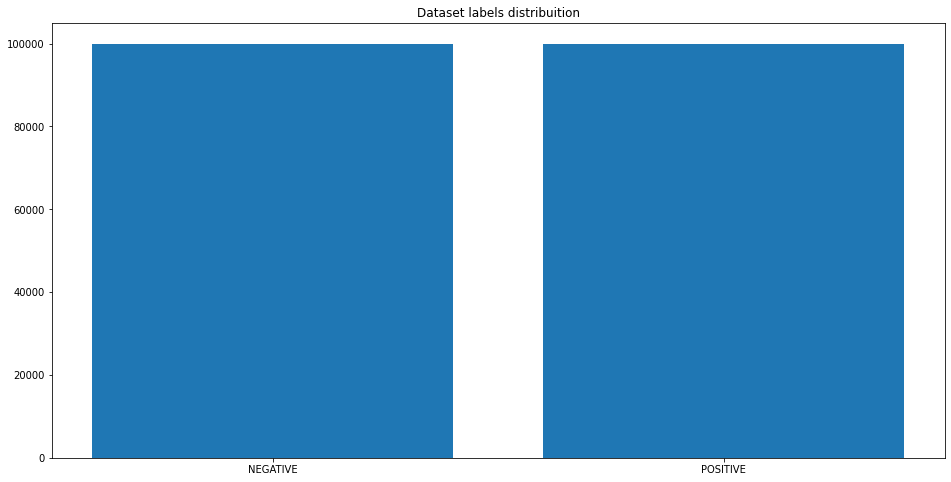

In [ ]:
target_cnt = Counter(df1.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

## Preprocessing the dataset

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

## Text Preprocessing

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
%%time
df1['text_clean'] = df1.text.apply(lambda x: preprocess(x))


CPU times: user 6.94 s, sys: 31.8 ms, total: 6.97 s
Wall time: 6.98 s


In [ ]:
with pd.option_context('display.max_columns', None,'display.precision', 3,):
 print(df1.iloc[0:5,5:7])


                                                      text  \
513467   Yay for Jon and Kate + 8! boo for having to wo...   
317873   @TimothyH2O sorry about last night I would hav...   
1106322  Good Morning my Twitter Loves.....Have a wonde...   
430836   @jamesheart24 I am great.. 'Revising' for my l...   
1211267  @AmyyVee wehehehehe sorry.... :| ) So whats new?    

                                       text_clean  
513467               yay jon kate 8 boo work 10am  
317873         sorry last night would stayed left  
1106322  good morning twitter loves wonderful day  
430836              great revising last exam done  
1211267                wehehehehe sorry whats new  


Lemmatization

In [ ]:
# Lemmatization

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
def preprocess_lemma(text):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
          tokens.append(lem.lemmatize(token))
            
    return " ".join(tokens)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
%%time
df1['text_clean'] = df1.text.apply(lambda x: preprocess_lemma(x))

CPU times: user 16.2 s, sys: 252 ms, total: 16.5 s
Wall time: 17 s


### Split train and test

In [ ]:
df_train, df_test = train_test_split(df1, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 160000
TEST size: 40000


In [ ]:
df1.head()

,target,ids,date,flag,user,text,text_clean
513467,NEGATIVE,2190392801,Tue Jun 16 02:35:58 PDT 2009,NO_QUERY,ericaaviles,Yay for Jon and Kate + 8! boo for having to wo...,yay jon kate 8 boo work 10am
317873,NEGATIVE,2002701375,Tue Jun 02 04:56:34 PDT 2009,NO_QUERY,janine_j9,@TimothyH2O sorry about last night I would hav...,sorry last night would stayed left
1106322,POSITIVE,1971410827,Sat May 30 07:02:48 PDT 2009,NO_QUERY,CandisDanielle,Good Morning my Twitter Loves.....Have a wonde...,good morning twitter love wonderful day
430836,NEGATIVE,2064416725,Sun Jun 07 06:12:25 PDT 2009,NO_QUERY,Portiaism,@jamesheart24 I am great.. 'Revising' for my l...,great revising last exam done
1211267,POSITIVE,1989134863,Mon Jun 01 00:27:37 PDT 2009,NO_QUERY,fadedmoon,@AmyyVee wehehehehe sorry.... :| ) So whats new?,wehehehehe sorry whats new


### Word2Vec 

In [ ]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 436 ms, sys: 81.6 ms, total: 518 ms
Wall time: 517 ms


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

2022-05-07 21:51:46,131 : INFO : collecting all words and their counts
2022-05-07 21:51:46,134 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-05-07 21:51:46,182 : INFO : PROGRESS: at sentence #10000, processed 131498 words, keeping 29401 word types
2022-05-07 21:51:46,227 : INFO : PROGRESS: at sentence #20000, processed 264153 words, keeping 50400 word types
2022-05-07 21:51:46,266 : INFO : PROGRESS: at sentence #30000, processed 395979 words, keeping 68911 word types
2022-05-07 21:51:46,310 : INFO : PROGRESS: at sentence #40000, processed 527689 words, keeping 85765 word types
2022-05-07 21:51:46,365 : INFO : PROGRESS: at sentence #50000, processed 659228 words, keeping 101721 word types
2022-05-07 21:51:46,408 : INFO : PROGRESS: at sentence #60000, processed 790690 words, keeping 116873 word types
2022-05-07 21:51:46,451 : INFO : PROGRESS: at sentence #70000, processed 923795 words, keeping 131573 word types
2022-05-07 21:51:46,496 : INFO : PROGRESS: 

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 11928


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2022-05-07 21:51:50,055 : INFO : training model with 8 workers on 11928 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2022-05-07 21:51:51,153 : INFO : EPOCH 1 - PROGRESS: at 24.60% examples, 317889 words/s, in_qsize 15, out_qsize 0
2022-05-07 21:51:52,156 : INFO : EPOCH 1 - PROGRESS: at 53.97% examples, 362036 words/s, in_qsize 15, out_qsize 0
2022-05-07 21:51:53,207 : INFO : EPOCH 1 - PROGRESS: at 80.41% examples, 358909 words/s, in_qsize 15, out_qsize 0
2022-05-07 21:51:53,820 : INFO : worker thread finished; awaiting finish of 7 more threads
2022-05-07 21:51:53,845 : INFO : worker thread finished; awaiting finish of 6 more threads
2022-05-07 21:51:53,866 : INFO : worker thread finished; awaiting finish of 5 more threads
2022-05-07 21:51:53,868 : INFO : worker thread finished; awaiting finish of 4 more threads
2022-05-07 21:51:53,893 : INFO : worker thread finished; awaiting finish of 3 more threads
2022-05-07 21:51:53,900 : INFO : worker thread finish

CPU times: user 3min 45s, sys: 1.82 s, total: 3min 46s
Wall time: 2min 5s


(44751051, 67515776)

In [ ]:
w2v_model.most_similar("love")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2022-05-07 21:53:55,171 : INFO : precomputing L2-norms of word weight vectors


[('LOVE', 0.5477240085601807),
 ('adore', 0.5449113845825195),
 ('luv', 0.5357214212417603),
 ('appreciate', 0.5325413942337036),
 ('loved', 0.5319006443023682),
 ('looove', 0.5158330202102661),
 ('loooove', 0.5033454298973083),
 ('Love', 0.4947524666786194),
 ('lovee', 0.4754341244697571),
 ('loves', 0.44460296630859375)]

### Tokenize Text

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 138203
CPU times: user 3.48 s, sys: 115 ms, total: 3.59 s
Wall time: 4.26 s


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 4.19 s, sys: 136 ms, total: 4.33 s
Wall time: 4.3 s


### Label Encoder 

In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (160000, 1)
y_test (40000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (160000, 300)
y_train (160000, 1)

x_test (40000, 300)
y_test (40000, 1)


In [ ]:
y_train[:10]

array([[1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0]])

### Embedding layer

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(138203, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2022-05-07 21:54:08,897 : WARNING : Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          41460900  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 41,621,401
Trainable params: 160,501
Non-trainable params: 41,460,900
_________________________________________________________________


### Compile model

In [ ]:
# model.compile(loss='binary_crossentropy',
#               optimizer="adam",
#               metrics=['accuracy'])

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-2),
              metrics=['accuracy'])


### Callbacks

In [ ]:
import tensorflow as tf 
import os
checkpoint_path='/content/drive/MyDrive/SentimentAnalysis/Checkpoint/model.{epoch:02d}-{val_loss:.2f}.h5'
checkpoint_dir=os.path.dirname(checkpoint_path)
filename = 'Logs.csv'

my_callbacks = [
    # Stop training if validation error stays within 0.00001 for three rounds.
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                     min_delta=0.00001,
                                     patience=3),
    # Save the weights of the best performing model to the checkpoint folder.
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       save_best_only=True,
                                       save_weights_only=True),
                
    tf.keras.callbacks.CSVLogger(filename, separator = "," , append = True)
]



In [ ]:
# callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
#               EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=8,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=my_callbacks)

Epoch 1/8
141/141 [==============================] - 264s 2s/step - loss: 0.5308 - accuracy: 0.7328 - val_loss: 0.4708 - val_accuracy: 0.7781
Epoch 2/8
141/141 [==============================] - 257s 2s/step - loss: 0.4976 - accuracy: 0.7574 - val_loss: 0.4627 - val_accuracy: 0.7839
Epoch 3/8
141/141 [==============================] - 254s 2s/step - loss: 0.4889 - accuracy: 0.7621 - val_loss: 0.4644 - val_accuracy: 0.7784
Epoch 4/8
141/141 [==============================] - 255s 2s/step - loss: 0.4874 - accuracy: 0.7626 - val_loss: 0.4620 - val_accuracy: 0.7818
Epoch 5/8
141/141 [==============================] - 298s 2s/step - loss: 0.4827 - accuracy: 0.7662 - val_loss: 0.4613 - val_accuracy: 0.7834
Epoch 6/8
141/141 [==============================] - 263s 2s/step - loss: 0.4803 - accuracy: 0.7679 - val_loss: 0.4580 - val_accuracy: 0.7844
Epoch 7/8
141/141 [==============================] - 260s 2s/step - loss: 0.4817 - accuracy: 0.7670 - val_loss: 0.4557 - val_accuracy: 0.7861
Epoch 

In [ ]:
model.save('/content/drive/MyDrive/SentimentAnalysis/LSTM.h5')

In [ ]:
import tensorflow.keras as keras
model = keras.models.load_model('/content/drive/MyDrive/SentimentAnalysis/LSTM.h5')

2022-05-07 21:54:09,779 : WARNING : Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


In [ ]:
model.load_weights('/content/drive/MyDrive/SentimentAnalysis/Checkpoint/model.08-0.45.h5')

In [ ]:
l1 = model.history.history['loss']
vl1 = model.history.history['val_loss']

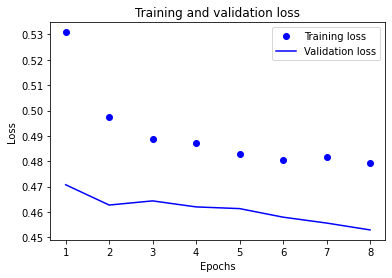

In [ ]:
loss = l1
val_loss = vl1
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=12,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=my_callbacks)

Epoch 1/12
141/141 [==============================] - 258s 2s/step - loss: 0.4757 - accuracy: 0.7713 - val_loss: 0.4607 - val_accuracy: 0.7854
Epoch 2/12
141/141 [==============================] - 251s 2s/step - loss: 0.4754 - accuracy: 0.7706 - val_loss: 0.4518 - val_accuracy: 0.7883
Epoch 3/12
141/141 [==============================] - 252s 2s/step - loss: 0.4739 - accuracy: 0.7712 - val_loss: 0.4517 - val_accuracy: 0.7887
Epoch 4/12
141/141 [==============================] - 251s 2s/step - loss: 0.4732 - accuracy: 0.7715 - val_loss: 0.4519 - val_accuracy: 0.7901
Epoch 5/12
141/141 [==============================] - 243s 2s/step - loss: 0.4713 - accuracy: 0.7725 - val_loss: 0.4484 - val_accuracy: 0.7894
Epoch 6/12
141/141 [==============================] - 245s 2s/step - loss: 0.4703 - accuracy: 0.7737 - val_loss: 0.4497 - val_accuracy: 0.7911
Epoch 7/12
141/141 [==============================] - 244s 2s/step - loss: 0.4697 - accuracy: 0.7755 - val_loss: 0.4482 - val_accuracy: 0.7924

In [ ]:
l2 = model.history.history['loss']
vl2 = model.history.history['val_loss']

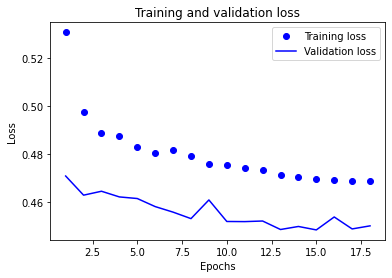

In [ ]:
loss = l1 + l2
val_loss = vl1 + vl2
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluate

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

40/40 [==============================] - 9s 235ms/step - loss: 0.4515 - accuracy: 0.7895

ACCURACY: 0.7894999980926514
LOSS: 0.4515473246574402
CPU times: user 6.74 s, sys: 2.04 s, total: 8.78 s
Wall time: 10.3 s


### Predict

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love the music")

{'elapsed_time': 0.4997375011444092,
 'label': 'POSITIVE',
 'score': 0.9832963347434998}

In [ ]:
predict("I hate the rain")

{'elapsed_time': 0.1633608341217041,
 'label': 'NEGATIVE',
 'score': 0.009592372924089432}

In [ ]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.16228389739990234,
 'label': 'NEGATIVE',
 'score': 0.2085791975259781}

### Confusion Matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

5/5 [==============================] - 7s 1s/step
CPU times: user 3.96 s, sys: 2.78 s, total: 6.73 s
Wall time: 6.88 s


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

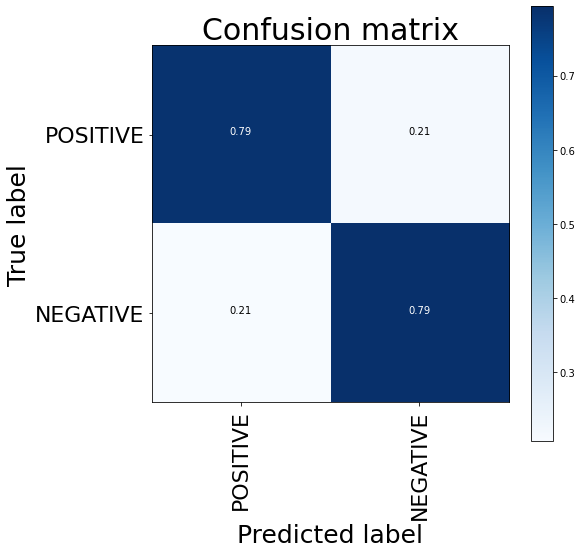

CPU times: user 592 ms, sys: 0 ns, total: 592 ms
Wall time: 728 ms


In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.79      0.79     19921
    POSITIVE       0.79      0.79      0.79     20079

    accuracy                           0.79     40000
   macro avg       0.79      0.79      0.79     40000
weighted avg       0.79      0.79      0.79     40000



### Accuracy Score

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

0.7895

AUC


In [ ]:

y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]


5/5 [==============================] - 6s 1s/step


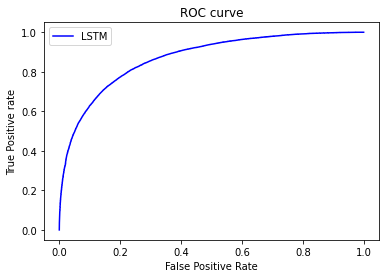

In [ ]:
y_pred2 = model.predict(x_test)
# y_test_1d, y_pred_1d

fpr1l, tpr1l, thresh1l = roc_curve(y_test, y_pred2, pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr1l, tpr1l, linestyle='-',color='blue', label='LSTM')
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();


In [ ]:
auc_score1l = roc_auc_score(y_test, y_pred2)

auc_score1l

0.8696418110863575

### Save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2022-04-15 21:52:19,944 : INFO : saving Word2Vec object under model.w2v, separately None
2022-04-15 21:52:19,946 : INFO : not storing attribute vectors_norm
2022-04-15 21:52:19,952 : INFO : not storing attribute cum_table
2022-04-15 21:52:20,247 : INFO : saved model.w2v
